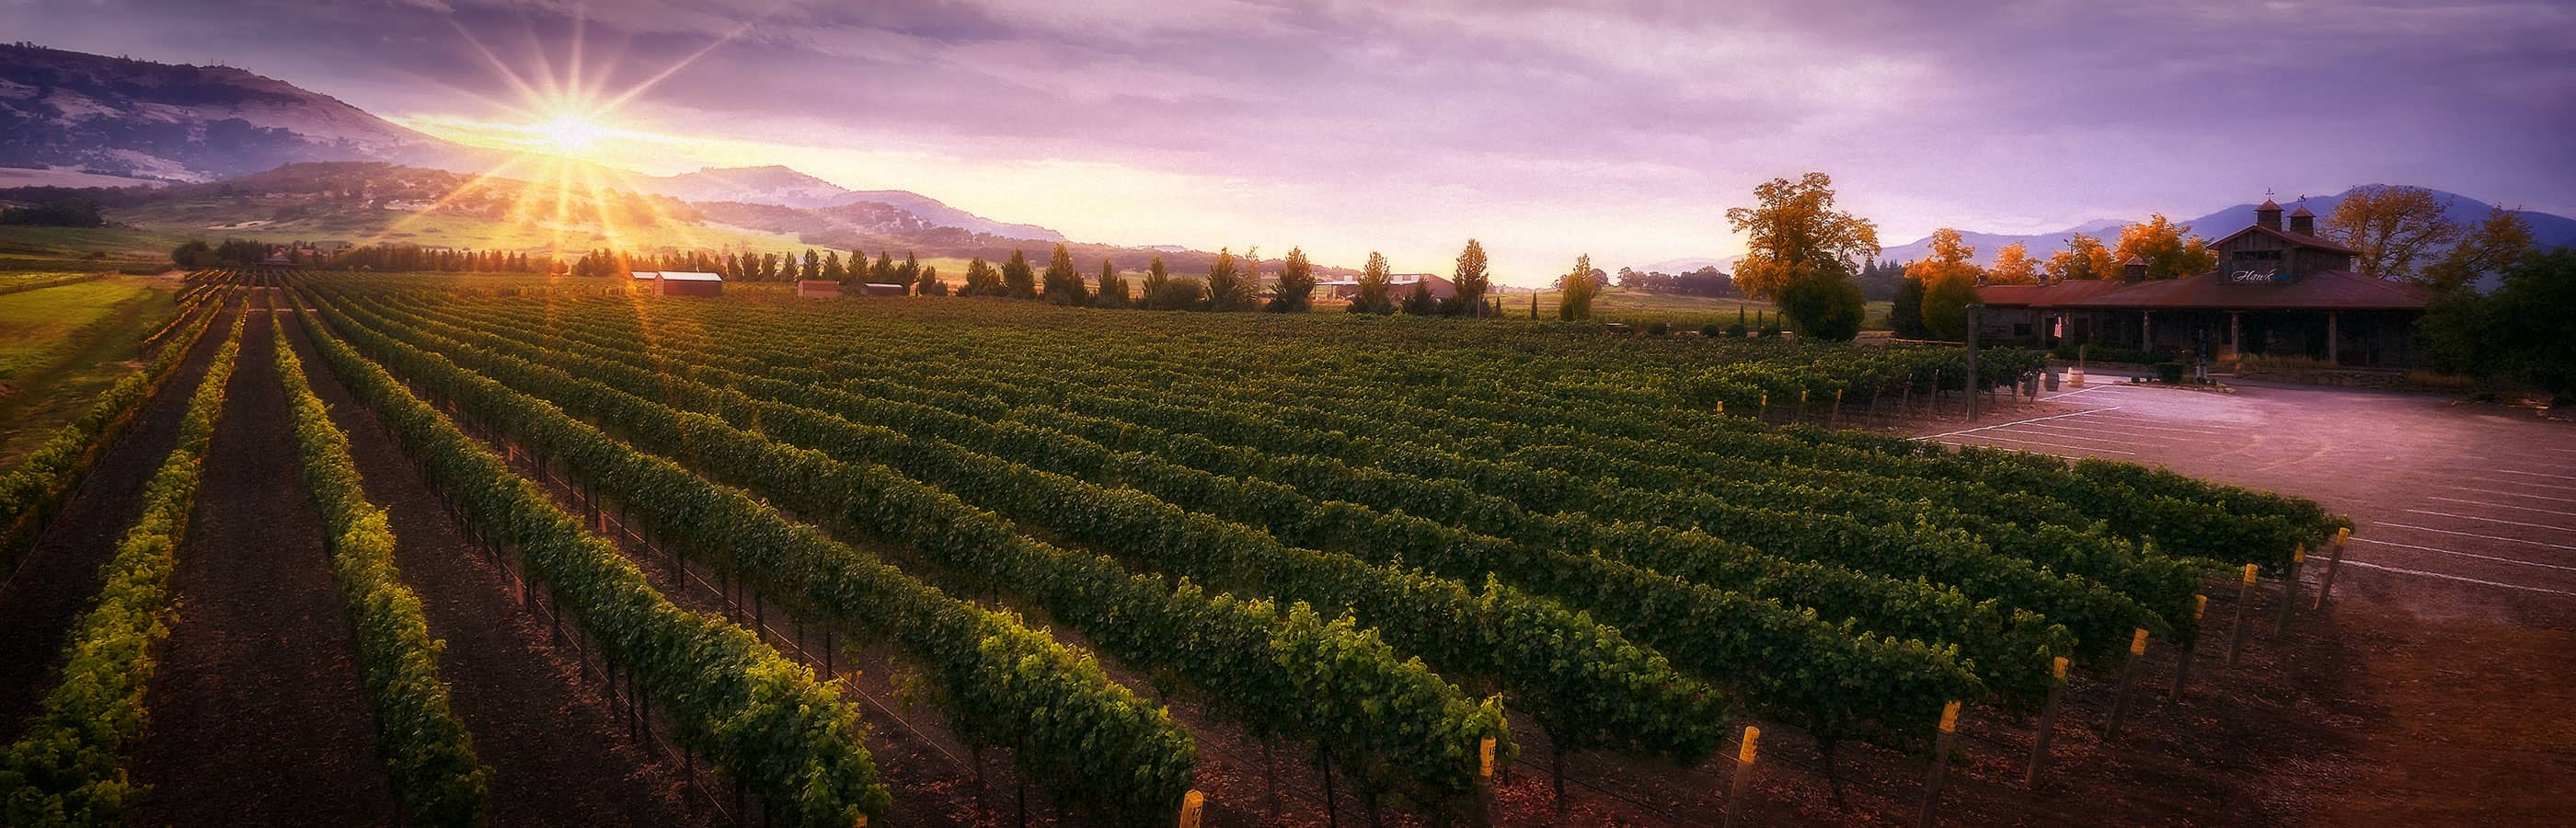

# Wine Ratings Project
## Team: Sparkly Scholars

Authors: 
Jian Cui, Sara Li, Ricky Pickering, Paul Rudrendu (Team Lead)

## Problem Statement


Wine processes an almost universal cultural, culinary, and religious significance. Globally there are thousands of vineyards, producing wine from a highly diverse variety of grapes. The result is a highly fragmented industry leaving customers and distributors awash in varietals, vineyards and bottles. Navigating this fragmented sea of variety are wine store owners. These owners rely on wine reviews to discern the quality of a wine. However, not all wines are reviewed by wine reviewers and new wines can have a shortage of reviews. To solve this issue we’re turning to machine learning to attempt to virtually drink a glass of wine and predict a score. We believe this scoring methodology will help improve the review coverage for wines, especially wines that are new.

# Wine Reviews

**Data Source:** https://www.kaggle.com/zynicide/wine-reviews

**Context**

Inspired by Somm, a documentary on master sommeliers, the author created a predictive model that could identify wines through blind tasting. Data collection was the first step in the author's journey. The model should be ideally be able to identify the wine from the description provided without the need for someone to physically taste the wine.

The author created the dataset by scraping the data from WineEnthusiast, https://www.winemag.com/?s=&drink_type=wine. The dataset was last updated on 11/24/2017.


**Dataset used for analysis:** winemag-data_first150k.csv 

It consists of 10 columns and 150k rows of wine reviews.

**Columns in this Dataset**

|Column Name|Description|Type|
|--|--|--|
|id number|.|String|
|country| The country that the wine is from.|String|
|description|.|String| 
|designation|The vineyard within the winery where the grapes that made the wine are from.|String|
|points|The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80).|Double|
|price| The cost for a bottle of the wine.|Double|
|province| The province or state that the wine is from.|String|
|region_1|The wine growing area in a province or state (ie Napa).|String|
|region_2| Sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank.|String|
|variety|The type of grapes used to make the wine (ie Pinot Noir)|String|
|winery|The winery that made the wine.|String| 

## Environment Config and Data Load

### Importing all the libraries 

In [359]:
!conda install pandas

Solving environment: done

# All requested packages already installed.



In [360]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
from pyspark.sql.functions import *

### Config Data File Paths

In [361]:
bucket = spark._jsc.hadoopConfiguration().get("fs.gs.system.bucket")

data = "gs://" + bucket + "/notebooks/data/"
print(data)

gs://is843-bigdata-project-bucket/notebooks/data/


### Read data into Spark

In [362]:
wine = spark.read.format("csv")\
         .option("header", "true")\
         .option("inferSchema", "true")\
         .load(data + "wine-reviews/winemag-data_first150k.csv")

# Print the Schema of loaded wine dataset
wine.printSchema()

# Print number of records in the dataset. 
print("Number of rows in the dataset {}".format(wine.count()))

root
 |-- _c0: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- designation: string (nullable = true)
 |-- points: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- province: string (nullable = true)
 |-- region_1: string (nullable = true)
 |-- region_2: string (nullable = true)
 |-- variety: string (nullable = true)
 |-- winery: string (nullable = true)

Number of rows in the dataset 150930


### Renaming the missing header column

In this section wer are loading additional libraries and selecting the columns we will be using for analysis. In this section we have renamed _c0 to id. This is to give the programmers a more descriptive name to work with.

In [363]:
from pyspark.sql.types import *

wine = wine.select(col("_c0").alias("id"), col("country"), col("designation"), \
                    col("points").cast(DoubleType()), col("price").cast(DoubleType()), col("province"),  \
                    col("region_1"),  col("region_2"), col("variety"),  col("winery"))

# Print Schema to confirm selection and renaming of data
wine.printSchema()

root
 |-- id: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- designation: string (nullable = true)
 |-- points: double (nullable = true)
 |-- price: double (nullable = true)
 |-- province: string (nullable = true)
 |-- region_1: string (nullable = true)
 |-- region_2: string (nullable = true)
 |-- variety: string (nullable = true)
 |-- winery: string (nullable = true)



### Checking for missing data

The following funciton will check each column and count the number of Null values. region_1 and region_2 have a significant number of missing values. This is due to the fact that province, region_1 and region_2 are a hirearchy with province being the most broad level and region_2 being the most specific. For provinces with a few number of vinyards region_1 and region_2 are uncessary and left blank.

In [364]:
[(c, wine.where(col(c).isNull()).count()) for c in wine.columns]

[('id', 0),
 ('country', 5),
 ('designation', 45735),
 ('points', 0),
 ('price', 13695),
 ('province', 5),
 ('region_1', 25060),
 ('region_2', 89977),
 ('variety', 0),
 ('winery', 0)]

### Checking for number of rows with at least 1 missing data point

Within the dataset 26% of rows have at least one missing data elements. This is mostly due to the absence of data for region_2

In [365]:
print ("% of total rows consisting of at least 1 missing data point in entire dataset")
n = wine.na.drop().count()
m = (n/wine.count())*100

float(m)

% of total rows consisting of at least 1 missing data point in entire dataset


25.999469952958325

Remove columns id and description as they will not be used in the evaluation of the wimes. 

In [366]:
# Dropping unnecessary columns; id and description

wine = wine.select("country", "designation", "points", "price",
                    "province", "region_1", "region_2", "variety", "winery")
wine.show(1)

+-------+-----------------+------+-----+----------+-----------+--------+------------------+------+
|country|      designation|points|price|  province|   region_1|region_2|           variety|winery|
+-------+-----------------+------+-----+----------+-----------+--------+------------------+------+
|     US|Martha's Vineyard|  96.0|235.0|California|Napa Valley|    Napa|Cabernet Sauvignon| Heitz|
+-------+-----------------+------+-----+----------+-----------+--------+------------------+------+
only showing top 1 row



### Creating copies of original data for model fitting

In [367]:
# for logistic regression with all features

wine_reg = wine

# for logistic regrssion and hyper parameter tuning using pipeline model with limited features 
# Comparing the improvement in auc value from hyperparameter tuning over the usual model with the same set of features

wine_reg_pipeline = wine 

## Dataset Descriptive analytics

### Country

#### Average price & points for each country

For analytical purposes it is informative to aggregate the data by various dimensions. Here we are looking at the average points and prices for wines by their country of origin. For the purposes of aggregation we have filterd out any country that has fewer than 100 wines. With few wines small countries can rise up to the top of the rankings and look more important than they are. 

Here we can see the four countries with the highest points are all of European origin. 

In [368]:
wine_country = wine.groupBy("country").agg(avg("points"),avg("price"), count(lit(1)).alias("records"))
wine_country_points = wine_country\
  .select(col("country"), 
          round(col("avg(points)"), 1).alias("avg_points"),
          round(col("avg(price)"), 1).alias("avg_price"),
          col("records").alias("Num of Records"))\
          .where(col("records") > 100)\
          .orderBy(desc("avg_points"))

# Convert to Pandas for better presentation
wine_country_points.toPandas().head(5)

,country,avg_points,avg_price,Num of Records
0,Austria,89.3,31.2,3057
1,France,88.9,45.6,21098
2,Germany,88.6,39.0,2452
3,Italy,88.4,37.5,23478
4,Canada,88.2,34.6,196


### Top 3 countries that selling the most expensive wines in general

Here we can see the nations with the highest average price for wine. France leads the rankings by price. France also appeared as the country with the second highest average points per wine. This suggests that French wines are high quality but command a slight price premium over other nations.

In [369]:
wine_country_points.orderBy("avg_price", ascending = 0, truncate = False).toPandas().head(5)

,country,avg_points,avg_price,Num of Records
0,France,88.9,45.6,21098
1,Hungary,87.3,44.2,231
2,Germany,88.6,39.0,2452
3,Italy,88.4,37.5,23478
4,Canada,88.2,34.6,196


### Wine Cost Performance

Distributors and customers looking to maximize the quality of their wine per unit cost should consider the ratio of the average points of a wine over the cost of the wine. Here we can see countries such as Romania, Chile, and South Aftica produce quality wines at a decent price. 

In [370]:
wine_country_costperformance = wine_country_points\
    .select(
      col("country"),
      round(col("avg_points")/col("avg_price"), 2)\
        .alias("cost_performance"),
      col("avg_points").alias("Avg Points"),
      col("avg_price").alias("Avg Price"),
      col("Num of Records")
    )\
    .orderBy(desc("cost_performance"))

wine_country_costperformance.toPandas().head(5)

,country,cost_performance,Avg Points,Avg Price,Num of Records
0,Romania,5.18,84.9,16.4,139
1,Chile,4.47,86.3,19.3,5816
2,Argentina,4.13,86.0,20.8,5631
3,South Africa,4.13,87.2,21.1,2258
4,Greece,3.97,86.1,21.7,884


## Designation

### Average price & points for each designation

In [371]:
wine_designation = \
   wine.groupBy("designation")\
   .agg(
       avg("points"), 
       avg("price"), 
       count(lit(1)).alias("records")
   )

wine_designation = \
    wine_designation\
    .where(col("records") > 200)\
    .where(col("designation") != "None")\
    .select(
        col("designation"), 
        round(col("avg(points)"), 1).alias("avg_points"), 
        round(col("avg(price)"), 1).alias("avg_price"),
        col("records").alias("Num of Records"))
# Filtered out wines without a designation.

wine_designation.toPandas().head(5)

,designation,avg_points,avg_price,Num of Records
0,Barrel Sample,91.2,112.3,639
1,Brut,87.4,30.1,624
2,Vieilles Vignes,89.2,38.3,225
3,Barrel sample,91.7,73.3,1326
4,Estate Bottled,86.9,28.4,396


## Province

### Average price & points for each province

All three west coast states in the United States break the top 10 list of wine growing provinces / states. Interestingly wines out of Washington have significantly higher points at a lower price than wines produced in California.

In [372]:
wine_province = \
    wine.groupBy("province", "country")\
    .agg(avg("points"), avg("price"), count(lit(1)).alias("records"))

wine_province = \
    wine_province\
    .where(col("records") > 10)\
    .select(
        col("province"), 
        col("country"),
        round(col("avg(points)"), 1).alias("avg_points"), 
        round(col("avg(price)"), 1).alias("avg_price"),
        col("records").alias("Num of Records"))\
    .orderBy(desc("Num of Records"))

wine_province.toPandas().head(5)

,province,country,avg_points,avg_price,Num of Records
0,California,US,87.7,35.5,44508
1,Washington,US,88.9,29.4,9750
2,Tuscany,Italy,89.3,48.1,7281
3,Bordeaux,France,89.5,42.6,6111
4,Northern Spain,Spain,86.8,30.2,4892


## Variety

### Average price & points for each variety

In [373]:
wine_variety = \
    wine.groupBy("variety")\
    .agg(avg("points"),
         avg("price"), 
         count(lit(1)).alias("records"))

wine_variety = \
    wine_variety\
    .select(
        col("variety"), 
        round(col("avg(points)"), 1).alias("avg_points"),
        round(col("avg(price)"), 1).alias("avg_price"),
        round(col("avg(points)")/col("avg(price)"), 1).alias("Points/Price"),
        col("records").alias("Num of Records"))\
    .where(col("Num of Records") > 100)\
    .orderBy(desc('avg_points'))

wine_variety.toPandas().head(5)

,variety,avg_points,avg_price,Points/Price,Num of Records
0,Nebbiolo,90.5,66.4,1.4,2241
1,Sangiovese Grosso,90.3,60.6,1.5,1346
2,Champagne Blend,90.0,78.6,1.1,1238
3,Bordeaux-style White Blend,89.5,36.7,2.4,1261
4,Bordeaux-style Red Blend,89.5,49.2,1.8,7347


## Winery

### Average price & points for each winery

In [374]:
wine_winery = \
    wine\
    .groupBy("winery", "country", "province")\
    .agg(avg("points"),
         avg("price"), 
         count(lit(1)).alias("records"))

wine_winery = \
    wine_winery\
    .select(col("winery"), 
            col("country"),
            col("province"),
            round(col("avg(points)"), 1).alias("avg_points"),
            round(col("avg(price)"), 1).alias("avg_price"),
            col("records").alias("Num of Records"))\
    .where(col("Num of Records") > 100)\
    .orderBy(desc("avg_points"))

wine_winery.toPandas().head(5)

,winery,country,province,avg_points,avg_price,Num of Records
0,Louis Jadot,France,Burgundy,92.5,107.0,120
1,Merry Edwards,US,California,92.5,51.3,102
2,Williams Selyem,US,California,92.3,57.0,374
3,K Vintners,US,Washington,92.1,45.9,103
4,Bründlmayer,Austria,Kamptal,91.5,47.1,112


## Wine Analytics

### Correlation between points and price

Correlation does not mean causation, however it can be an informative starting place for deeper analytics. Here we can see that there is some correlation between the price of a wine and the amount of points a review will give the wine.

In [375]:
cor = wine.select(corr("points", "price")).collect()[0][0]

cor = str(cor*100)

print("There is a " + cor + " % correlation between a wine's price and the number of points it receives")

There is a 45.98634287426058 % correlation between a wine's price and the number of points it receives


### Plotting and Histograms

#### Histogram of Points

In [376]:
# Set plotting style.
plt.style.use('ggplot')

Text(0.5, 0, 'Points')

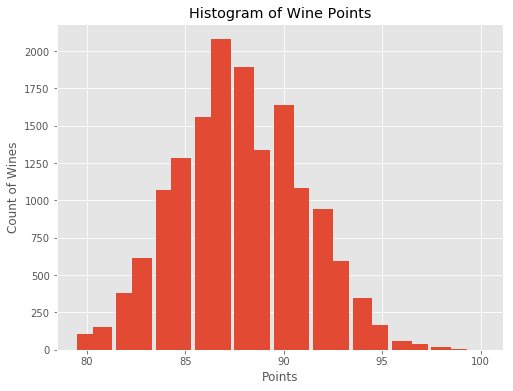

In [377]:
wine_points_hist = wine.sample(withReplacement = False, fraction = 0.10, seed = 8)\
    .where("points > 70")\
    .select(col("points"))\
    .rdd.flatMap(
        lambda row: row
    ).histogram(50)

data = {
    'bins': wine_points_hist[0][:-1],
    'freq': wine_points_hist[1]
}

plt.bar(data['bins'], data['freq'], width = 1 )
plt.title('Histogram of Wine Points')
plt.ylabel("Count of Wines")
plt.xlabel("Points")

We can see that the distribution of points is normally distributed. The curve exhibits little in terms of positive or negative skew. 

### Histogram of wine prices

Text(0.5, 0, 'Price')

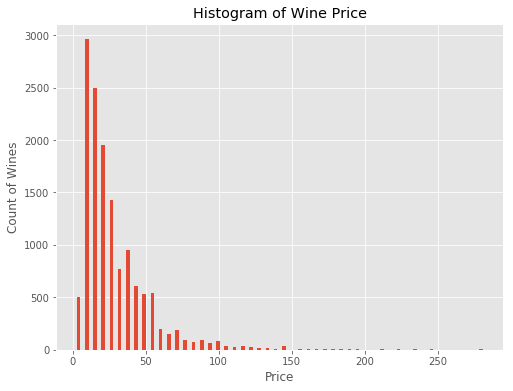

In [378]:
wine_price_hist = wine.sample(withReplacement = False, fraction = 0.10, seed = 8)\
    .where("price < 300")\
    .select(col("price"))\
    .rdd.flatMap(
        lambda row: row
    ).histogram(50)

data = {
    'bins': wine_price_hist[0][:-1],
    'freq': wine_price_hist[1]
}

plt.bar(data['bins'], data['freq'], width = 2.5 )
plt.title('Histogram of Wine Price')
plt.ylabel("Count of Wines")
plt.xlabel("Price")

A simple linear analysis of wine prices shows that the distibution has some extreme positive skew. This is due to a number of very expensive wines pulling the right tail out. Below we will attempt to correct this by taking the log of prices and visualizing. 

### Histogram of log prices

Text(0.5, 0, 'Price')

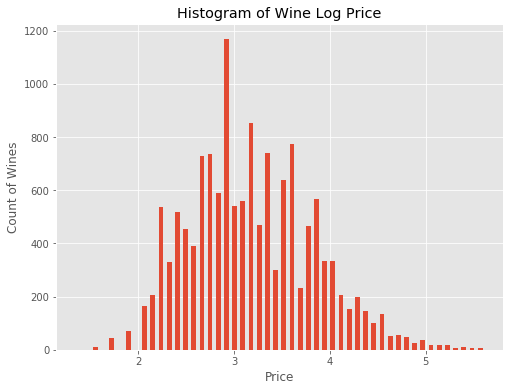

In [379]:
wine_price_hist = wine.sample(withReplacement = False, fraction = 0.10, seed = 8)\
    .where("price < 300")\
    .select(log(col("price")))\
    .rdd.flatMap(
        lambda row: row
    ).histogram(50)

data = {
    'bins': wine_price_hist[0][:-1],
    'freq': wine_price_hist[1]
}

plt.bar(data['bins'], data['freq'], width = .05)
plt.title('Histogram of Wine Log Price')
plt.ylabel("Count of Wines")
plt.xlabel("Price")

By taking the log of the prices were able to deflate the prices of extremely expensive wines. The result is a distribution that is closer to matching a normal distribution. For analysis using the price of wine we should use the log(price). 

### Scatter plot of wine prices to points

Text(0.5, 0, 'Price')

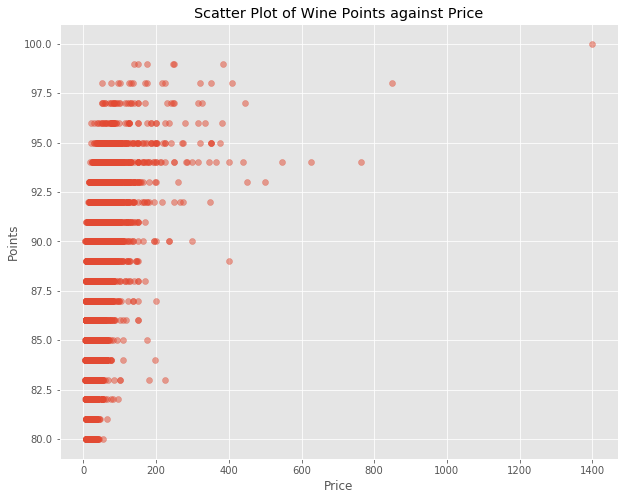

In [380]:
# It's interesting to see that the wines with same rating have very different price.

wine_price_points = wine.sample(withReplacement = False, fraction = 0.10, seed = 8).toPandas()
plt.figure(figsize=(10,8))
plt.scatter(wine_price_points['price'], wine_price_points['points'], alpha=0.5)
plt.title('Scatter Plot of Wine Points against Price')
plt.ylabel("Points")
plt.xlabel("Price")

In the linear scale, points (on average for the sampled dataset) does not seem to increase linearly with price. Lets explore the logarithmic scale. 

### Linear Regression with Log Price

In [381]:
# Since the wine price range is very large, it is not easy to tell the relations between price and rating point using arithmetic scale. 
# We think it makes more sense to use log price, which can show how rating points corresponds to the percentage change of price.

wineLog = wine.sample(withReplacement = False, fraction = 0.10, seed = 8).withColumn("priceLn", log(col("price")))
wineLog.toPandas().head(5)

,country,designation,points,price,province,region_1,region_2,variety,winery,priceLn
0,US,Martha's Vineyard,96.0,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,5.459586
1,US,Grace Vineyard,95.0,185.0,Oregon,Dundee Hills,Willamette Valley,Pinot Noir,Domaine Serene,5.220356
2,France,Nonpareil Trésor Rosé Brut,90.0,22.0,France Other,Vin Mousseux,None,Sparkling Blend,Bouvet-Ladubay,3.091042
3,Spain,Alfonso Oloroso Seco,90.0,26.0,Andalucia,Jerez,None,Palomino,González Byass,3.258097
4,Italy,None,90.0,50.0,Tuscany,Brunello di Montalcino,None,Sangiovese,Brunelli Martoccia,3.912023


Text(0.5, 0, 'Log Price')

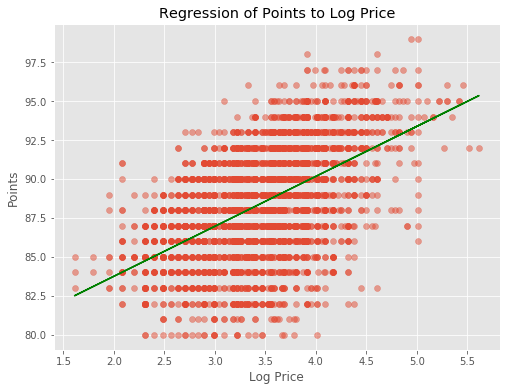

In [382]:
from numpy import polyfit

wineLogScatter = wineLog.na.drop().toPandas()

y = wineLogScatter['points'].values.tolist()
x = wineLogScatter['priceLn'].values.tolist()

fit = polyfit(x, y, 1)

plt.scatter(wineLogScatter['priceLn'], wineLogScatter['points'], alpha=0.5)
plt.plot(x, np.polyval(fit, x), 'g-' )
plt.title("Regression of Points to Log Price")
plt.ylabel("Points")
plt.xlabel("Log Price")

Using log price, we can see a strong logarithmic relationship between the Points given a wine and the Price of a wine. There is still significant unexplained variance in the model, but it is clear log(price) will be an interesting regressor / feature to use in predicting the price of a wine.

## Generalized Function to View Scatter

### Define funcitons for analysis

This function will allow us to create many different regression scatter plots against the dataset. The function will filter the dataset to a smaller subset and allow us to look different regressions. The fltrCol parameter definest the column we will be filtering on. The fltrVal column will specify what we want to have returned back to us. Other variables are for styling and for displaying of the scatter or not. 

In [383]:
# Define Function
def ScatterFunc(wineLog, 
                yCol = "points", 
                xCol = "priceLn", 
                fltrCol = "variety", 
                fltrVal = "Nebbiolo",
                pltClr = "Red",
                lnClr = "Blue",
                dispSctr = True):

    wineLogScatter = \
        wineLog\
        .where(col(fltrCol) == fltrVal)\
        .select(col(xCol), 
                col(yCol))\
        .na.drop()\
        .toPandas()
    
    yData = wineLogScatter[yCol].values.tolist()
    xData = wineLogScatter[xCol].values.tolist()

    fit = polyfit(xData, yData, 1)
    
    if dispSctr == True:
        plt.scatter(wineLogScatter[xCol], wineLogScatter[yCol], alpha = 0.5, color = pltClr)
    plt.plot(xData, np.polyval(fit, xData), color = lnClr)
    plt.title("Regression of " + xCol + " to " + yCol + " where " + fltrCol + " equals " + fltrVal)
    plt.ylabel("Variable: " + yCol)
    plt.xlabel("Variable: " + xCol)
    return plt

### Regression for Pinot Noir

Below we can see the regression for wines of the Pinot Noir variety against Chardonnay. These are two popular varietal of wine and exhibit different scattering behaviors. For Chardonnays there is a collection of wines with higher prices and also higher 

#### Exhibit 1

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

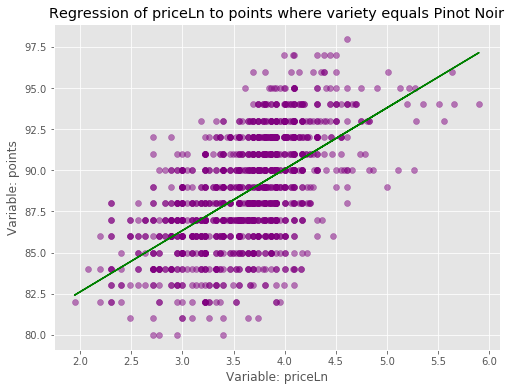

In [384]:
ScatterFunc(wineLog, fltrCol = "variety", fltrVal = "Pinot Noir", pltClr = "Purple", lnClr = 'Green')

#### Exhibit 2

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

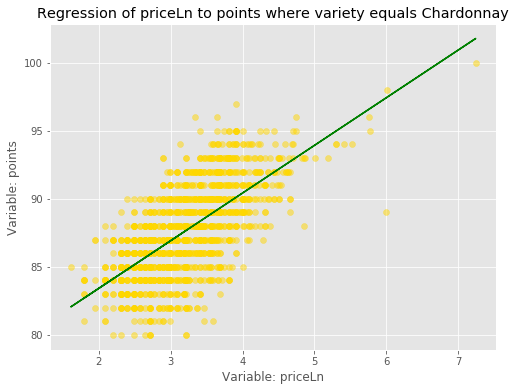

In [385]:
ScatterFunc(wineLog, fltrCol = "variety", fltrVal = "Chardonnay", pltClr = "Gold", lnClr = 'Green')

#### Exhibit 4

This shows the regression lines for Pinot Noir in Purple, and Chardonnay in Gold. We ca nsee that the coefficient for the Pinot Noir is higher than Chardonnay suggesting that price has more infulence of the points the wine recieves. 

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

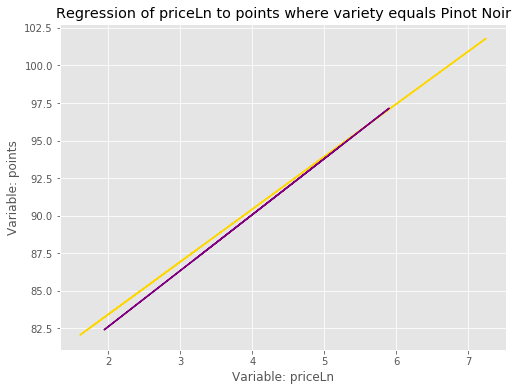

In [386]:
ScatterFunc(wineLog, fltrCol = "variety", fltrVal = "Chardonnay", pltClr = "Gold", dispSctr=False, lnClr = "Gold")
ScatterFunc(wineLog, fltrCol = "variety", fltrVal = "Pinot Noir", pltClr = "Purple", dispSctr=False, lnClr = "Purple")

### By Country

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

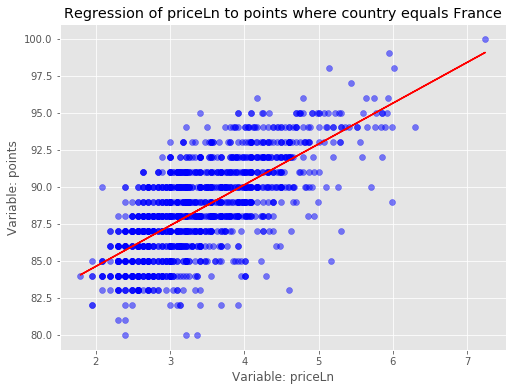

In [387]:
ScatterFunc(wineLog, fltrCol = "country", fltrVal = "France", pltClr = "Blue", lnClr = 'Red')

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

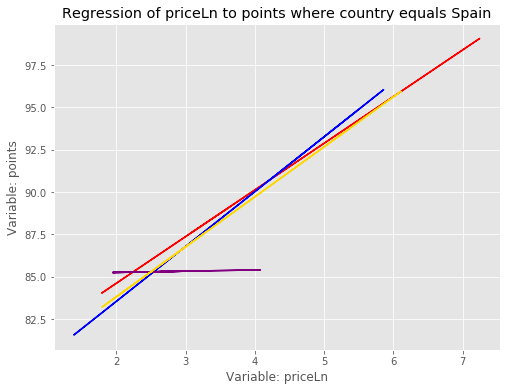

In [388]:
ScatterFunc(wineLog, fltrCol = "country", fltrVal = "France", pltClr = "Green", dispSctr = False, lnClr = 'Red')
ScatterFunc(wineLog, fltrCol = "country", fltrVal = "US", pltClr = "Green", dispSctr = False, lnClr = 'Blue')
ScatterFunc(wineLog, fltrCol = "country", fltrVal = "Romania", pltClr = "Green", dispSctr = False, lnClr = 'Purple')
ScatterFunc(wineLog, fltrCol = "country", fltrVal = "Spain", pltClr = "Green", dispSctr = False, lnClr = 'Gold')

Here we can see that French wines have the most sensitivity  to changes in the price level. This suggests that if a distributor wants to sell high quality wines at an affordable price, they may be able to find many bargins in France. However, the United States (Red) also has a higher intercept, suggesting a distributor could find quaility cheap wines in the United States when compared to other countires

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

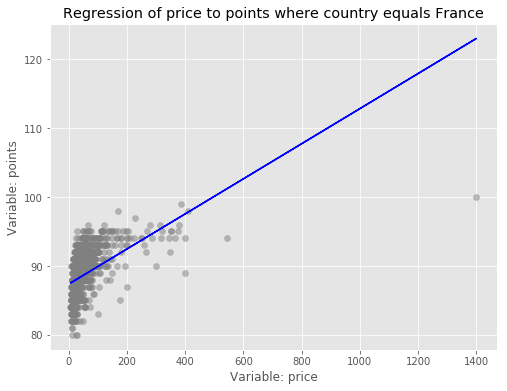

In [389]:
ScatterFunc(wineLog, xCol = 'price', yCol = 'points', fltrCol = "country", fltrVal = "France", pltClr = "Grey")

Here we can see how necessary it is to transform the price variable into a log relationship. Here we can see that the model creates a lot of errors when looking at high priced wines. 

# Logistic Regression to predict point levels/ buckets

# Part 1

### Logistic regression model

### Feature selection

#### Features in each categorical column type

In [390]:
wine_reg.show(2)

+-------+--------------------+------+-----+--------------+-----------+--------+------------------+--------------------+
|country|         designation|points|price|      province|   region_1|region_2|           variety|              winery|
+-------+--------------------+------+-----+--------------+-----------+--------+------------------+--------------------+
|     US|   Martha's Vineyard|  96.0|235.0|    California|Napa Valley|    Napa|Cabernet Sauvignon|               Heitz|
|  Spain|Carodorum Selecci...|  96.0|110.0|Northern Spain|       Toro|    null|     Tinta de Toro|Bodega Carmen Rod...|
+-------+--------------------+------+-----+--------------+-----------+--------+------------------+--------------------+
only showing top 2 rows



In [391]:
# Checking for missing values in each column before feature selection

[(c, wine_reg.where(col(c).isNull()).count()) for c in wine_reg.columns]

[('country', 5),
 ('designation', 45735),
 ('points', 0),
 ('price', 13695),
 ('province', 5),
 ('region_1', 25060),
 ('region_2', 89977),
 ('variety', 0),
 ('winery', 0)]

Note: the column, designation & region_2 should be dropped as it has a very high proportion of null values. 

In [392]:
# Checking for unique values in each column before feature selection

wine_reg.selectExpr("count(distinct(country))", "count(distinct(designation))", "count(distinct(province))", "count(distinct(region_1))").show()

wine_reg.selectExpr("count(distinct(region_2))", "count(distinct(variety))", "count(distinct(winery))").show()

+-----------------------+---------------------------+------------------------+------------------------+
|count(DISTINCT country)|count(DISTINCT designation)|count(DISTINCT province)|count(DISTINCT region_1)|
+-----------------------+---------------------------+------------------------+------------------------+
|                     48|                      30620|                     455|                    1236|
+-----------------------+---------------------------+------------------------+------------------------+

+------------------------+-----------------------+----------------------+
|count(DISTINCT region_2)|count(DISTINCT variety)|count(DISTINCT winery)|
+------------------------+-----------------------+----------------------+
|                      18|                    632|                 14810|
+------------------------+-----------------------+----------------------+



Note: The column winery should be dropped as it has a very high proportion of unique values compared to other columns, this can result in an error while evaluating the test set accuracy if the training set does not have all the unique values in the test set.

We need to drop winery as it has too many unique types and most of these types occur only once in the entire dataset

In [393]:
# Dropping unnecessary columns "designation" and "region_2"
wine_reg = wine_reg.drop('designation', 'region_2', 'winery') 

wine_reg.show(2)

+-------+------+-----+--------------+-----------+------------------+
|country|points|price|      province|   region_1|           variety|
+-------+------+-----+--------------+-----------+------------------+
|     US|  96.0|235.0|    California|Napa Valley|Cabernet Sauvignon|
|  Spain|  96.0|110.0|Northern Spain|       Toro|     Tinta de Toro|
+-------+------+-----+--------------+-----------+------------------+
only showing top 2 rows



In [394]:
wine_reg.select("points").summary().show()

+-------+-----------------+
|summary|           points|
+-------+-----------------+
|  count|           150930|
|   mean| 87.8884184721394|
| stddev|3.222391758983767|
|    min|             80.0|
|    25%|             86.0|
|    50%|             88.0|
|    75%|             90.0|
|    max|            100.0|
+-------+-----------------+



### Predicting the point level from all other factors using a logistic regression

For the classification problem, 2 classes/levels of points have been created, 

1. Class 0: points less than 75th percentile ( or 90 points)
2. Class 1: points greater than 75th percentile( or 90 points)

In [395]:
# Creatig the pointLevel column

wine_reg = wine_reg.select(expr("*"), 
                           when(col('points') >= 90,1).otherwise(0).alias("pointLevel"))  

wine_reg.select("pointLevel").summary().show()

+-------+-------------------+
|summary|         pointLevel|
+-------+-------------------+
|  count|             150930|
|   mean| 0.3194195984893659|
| stddev|0.46625332056848856|
|    min|                  0|
|    25%|                  0|
|    50%|                  0|
|    75%|                  1|
|    max|                  1|
+-------+-------------------+



In [396]:
wine_reg.show(2)

+-------+------+-----+--------------+-----------+------------------+----------+
|country|points|price|      province|   region_1|           variety|pointLevel|
+-------+------+-----+--------------+-----------+------------------+----------+
|     US|  96.0|235.0|    California|Napa Valley|Cabernet Sauvignon|         1|
|  Spain|  96.0|110.0|Northern Spain|       Toro|     Tinta de Toro|         1|
+-------+------+-----+--------------+-----------+------------------+----------+
only showing top 2 rows



In [397]:
# Dropping the numeric "points" column

wine_reg = wine_reg.drop('points')
wine_reg.show(2)

+-------+-----+--------------+-----------+------------------+----------+
|country|price|      province|   region_1|           variety|pointLevel|
+-------+-----+--------------+-----------+------------------+----------+
|     US|235.0|    California|Napa Valley|Cabernet Sauvignon|         1|
|  Spain|110.0|Northern Spain|       Toro|     Tinta de Toro|         1|
+-------+-----+--------------+-----------+------------------+----------+
only showing top 2 rows



#### Dropping all null values

In [398]:
# Number of rows before dropping any rows
print("Number of rows before dropping the null rows")
print(wine_reg.count())

# Dropping rows that contain null values
wine_reg = wine_reg.dropna()

# Number of rows before dropping any rows
print("Number of rows after dropping the null values")
print(wine_reg.count())

Number of rows before dropping the null rows
150930
Number of rows after dropping the null values
114393


In [399]:
# Checking for null values in each column

[(c, wine_reg.where(col(c).isNull()).count()) for c in wine_reg.columns]

[('country', 0),
 ('price', 0),
 ('province', 0),
 ('region_1', 0),
 ('variety', 0),
 ('pointLevel', 0)]

Defining the RFormula

In [400]:
from pyspark.ml.feature import RFormula
supervised = RFormula(formula="pointLevel ~ . ")

Fitting the RFormula transformer

In [401]:
fittedRF = supervised.fit(wine_reg)  # fit the transformer

In [402]:
preparedDF = fittedRF.transform(wine_reg)  # transform

preparedDF.select('features', 'label').show(2, False)

+------------------------------------------------+-----+
|features                                        |label|
+------------------------------------------------+-----+
|(1724,[0,6,7,69,1267],[1.0,235.0,1.0,1.0,1.0])  |1.0  |
|(1724,[3,6,10,147,1316],[1.0,110.0,1.0,1.0,1.0])|1.0  |
+------------------------------------------------+-----+
only showing top 2 rows



Creating the feature vector and storing it in the pandas DataFrame

In [403]:
featureCols = pd.DataFrame(preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
  preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureCols = featureCols.set_index('idx')
featureCols.head()

,name
idx,
0,country_US
1,country_Italy
2,country_France
3,country_Spain
4,country_Argentina


Creating the test and train set

In [404]:
train, test = preparedDF.randomSplit([0.7, 0.3], seed = 843)
test.show(2)

+---------+-----+----------------+--------+------------------+----------+--------------------+-----+
|  country|price|        province|region_1|           variety|pointLevel|            features|label|
+---------+-----+----------------+--------+------------------+----------+--------------------+-----+
|Argentina|  5.0|Mendoza Province| Mendoza|            Malbec|         0|(1724,[4,6,11,71,...|  0.0|
|Argentina|  6.0|Mendoza Province| Mendoza|Cabernet Sauvignon|         0|(1724,[4,6,11,71,...|  0.0|
+---------+-----+----------------+--------+------------------+----------+--------------------+-----+
only showing top 2 rows



### Logistic regression withOUT hyperparameter optimization

Text(0, 0.5, 'Beta Coefficients')

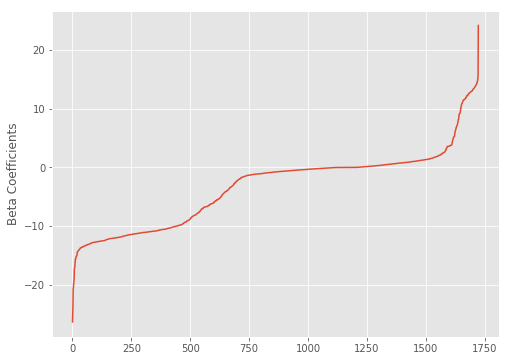

In [405]:
# Creating an instance of LogisticRegression

from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression()

lrModel = lr.fit(train) # Fitting the model on training set

# Plotting the coefficients of the model in sorted order 

plt.rcParams["figure.figsize"] = (8,6)

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')

#### Feature Importance

In [406]:
coefsArray = np.array(lrModel.coefficients)  # convert to np.array
coefsDF = pd.DataFrame(coefsArray, columns=['coefs'])  # to pandas

coefsDF = coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
coefsDF.sort_values('coefs', inplace=True)  # Sort them

In [407]:
coefsDF.head(10) # top 10 negatively correlated features

,coefs,name
976,-26.313473,region_1_Pouilly-sur-Loire
1617,-24.886934,variety_Torbato
1525,-23.594619,variety_Pansa Blanca
1028,-20.569469,region_1_Verdicchio di Matelica
938,-20.466966,region_1_Verdicchio dei Castelli di Jesi
1596,-19.714607,variety_Debit
1644,-19.551910,variety_Muscadet
1154,-18.910504,region_1_Medrano
982,-17.277291,region_1_Saddle Rock-Malibu
1144,-17.081708,region_1_Nevada


In [408]:
coefsDF.tail(10) # top 10 positively correlated features

,coefs,name
961,14.083715,region_1_Mâcon-Verze
1002,14.138647,region_1_Ventoux
1604,14.325751,variety_Edelzwicker
1239,14.337528,region_1_Chignin-Bergeron
1115,14.367930,region_1_Coteaux de Verdon
1111,14.709508,region_1_Biferno Rosso
1566,14.800344,variety_Trebbiano-Malvasia
933,15.204180,region_1_Vin de Liqueur
1133,15.683741,region_1_Vin de Pays de la Vallée de l’Aude
983,24.187524,region_1_Offida Passerina


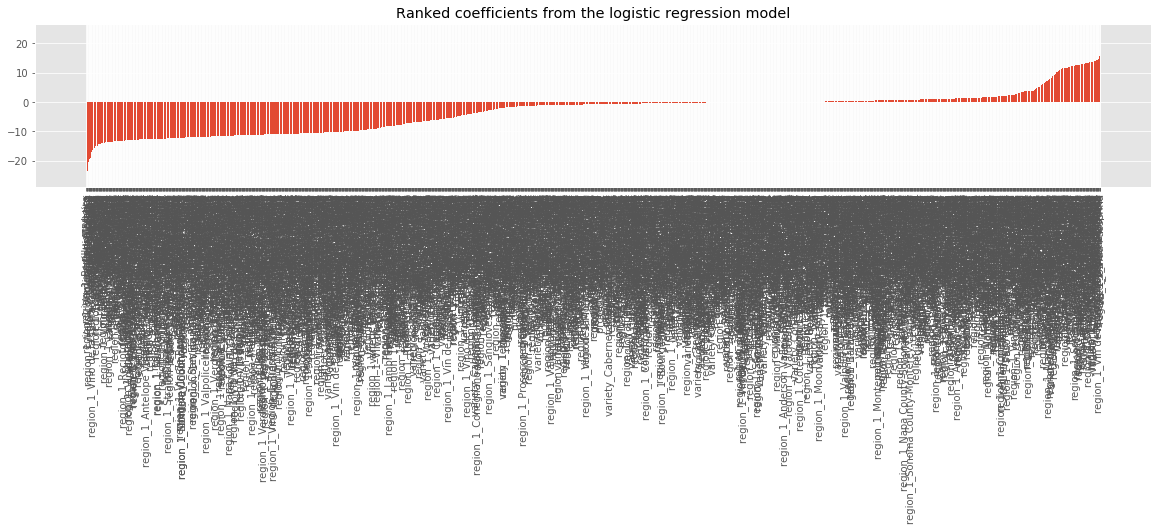

In [409]:
# Plotting the bar chart

plt.rcParams["figure.figsize"] = (20,3)

plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF.coefs)
plt.title('Ranked coefficients from the logistic regression model')
plt.show()

Train AUC value

In [410]:
# Fitted Model AUC value

summary = lrModel.summary
print("Train AUC:", summary.areaUnderROC)

Train AUC: 0.8555367657325181


Train ROC curve

Train AUC: 0.8555367657325181


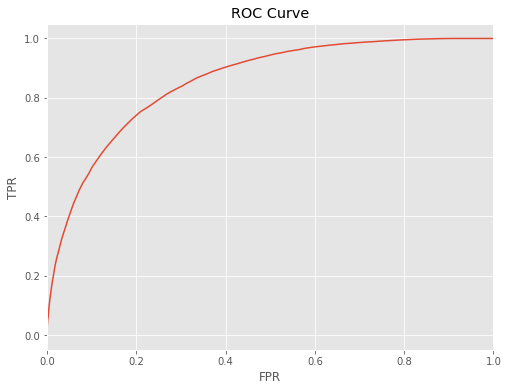

In [411]:
roc = summary.roc.toPandas()
roc.head()

plt.rcParams["figure.figsize"] = (8,6)

roc.plot(x='FPR', y='TPR', style='-', legend=False)
plt.title('ROC Curve')
plt.ylabel('TPR')

print('Train AUC:', summary.areaUnderROC)

Precision-recall curve

Text(0, 0.5, 'precision')

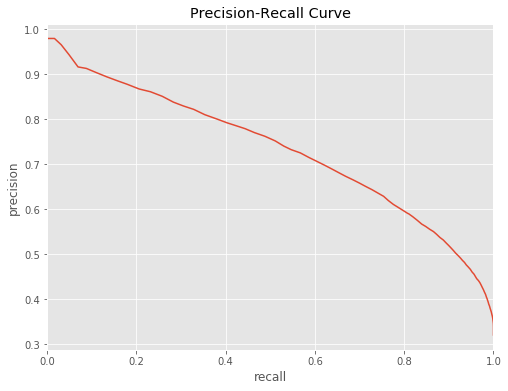

In [412]:
pr = summary.pr.toPandas()
pr.plot(x='recall', y='precision', style='-', legend=False)
plt.title('Precision-Recall Curve')
plt.ylabel('precision')

Test AUC

In [413]:
fittedTest = lrModel.transform(test)

fittedTest.select("label", "prediction", "rawPrediction").show(5, False)


from pyspark.ml.evaluation import BinaryClassificationEvaluator
aucEvaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

print('Test AUC:', aucEvaluator.evaluate(lrModel.transform(test)))
print('Train AUC:', summary.areaUnderROC)

# saving the baseline test auc value
test_auc_baseline = aucEvaluator.evaluate(lrModel.transform(test))

+-----+----------+----------------------------------------+
|label|prediction|rawPrediction                           |
+-----+----------+----------------------------------------+
|0.0  |0.0       |[2.69649033640441,-2.69649033640441]    |
|0.0  |0.0       |[2.954930886329229,-2.954930886329229]  |
|0.0  |0.0       |[2.643740152391035,-2.643740152391035]  |
|0.0  |0.0       |[2.5909899683776594,-2.5909899683776594]|
|0.0  |0.0       |[2.574880657808865,-2.574880657808865]  |
+-----+----------+----------------------------------------+
only showing top 5 rows

Test AUC: 0.8398886655951918
Train AUC: 0.8555367657325181


# Part 2

## Logistic regression model 

#### Compare model AUC (with same set of inputs) for the logistic regression models:
#### 1. without hyperparameter tuning
#### 2. with hyperparameter tuning using pipeline model

### Logistic regression model without hyperparameter tuning

#### Features in each categorical column type

In [414]:
wine_reg_pipeline.show(2)

+-------+--------------------+------+-----+--------------+-----------+--------+------------------+--------------------+
|country|         designation|points|price|      province|   region_1|region_2|           variety|              winery|
+-------+--------------------+------+-----+--------------+-----------+--------+------------------+--------------------+
|     US|   Martha's Vineyard|  96.0|235.0|    California|Napa Valley|    Napa|Cabernet Sauvignon|               Heitz|
|  Spain|Carodorum Selecci...|  96.0|110.0|Northern Spain|       Toro|    null|     Tinta de Toro|Bodega Carmen Rod...|
+-------+--------------------+------+-----+--------------+-----------+--------+------------------+--------------------+
only showing top 2 rows



Note: the column, designation & region_2 should be dropped as it has a very high proportion of null values. 

Note: The column winery should be dropped as it has a very high proportion of unique values compared to other columns, this can result in an error while evaluating the test set accuracy if the training set does not have all the unique values in the test set.

We need to drop winery as it has too many unique types and most of these types occur only once in the entire dataset

In [415]:
# Dropping unnecessary columns "designation" and "region_2"
wine_reg_pipeline = wine_reg_pipeline.drop('designation', 'region_2', 'winery')

In [416]:
# Modification for Pipeline model
# dropping more columns as including these are leading to errors in the pipeline model 

wine_reg_pipeline = wine_reg_pipeline.drop("region_1", "variety", "province")

### Predicting the point level from all other factors using a logistic regression

For the classification problem, 2 classes/levels of points have been created, 

1. Class 0: points less than 75th percentile ( or 90 points)
2. Class 1: points greater than 75th percentile( or 90 points)

In [417]:
# Creatig the pointLevel column

wine_reg_pipeline = wine_reg_pipeline.select(expr("*"), 
                           when(col('points') >= 90,1).otherwise(0).alias("pointLevel"))  

wine_reg_pipeline.select("pointLevel").summary().show()

+-------+-------------------+
|summary|         pointLevel|
+-------+-------------------+
|  count|             150930|
|   mean| 0.3194195984893659|
| stddev|0.46625332056848856|
|    min|                  0|
|    25%|                  0|
|    50%|                  0|
|    75%|                  1|
|    max|                  1|
+-------+-------------------+



In [418]:
wine_reg_pipeline.show(5)

+-------+------+-----+----------+
|country|points|price|pointLevel|
+-------+------+-----+----------+
|     US|  96.0|235.0|         1|
|  Spain|  96.0|110.0|         1|
|     US|  96.0| 90.0|         1|
|     US|  96.0| 65.0|         1|
| France|  95.0| 66.0|         1|
+-------+------+-----+----------+
only showing top 5 rows



In [419]:
# Dropping the numeric "points" column

wine_reg_pipeline = wine_reg_pipeline.drop('points')
wine_reg_pipeline.show(2)

+-------+-----+----------+
|country|price|pointLevel|
+-------+-----+----------+
|     US|235.0|         1|
|  Spain|110.0|         1|
+-------+-----+----------+
only showing top 2 rows



#### Dropping all null values

In [420]:
# Number of rows before dropping any rows
print("Number of rows before dropping the null rows")
print(wine_reg_pipeline.count())

# Dropping rows that contain null values
wine_reg_pipeline = wine_reg_pipeline.dropna()

# Number of rows before dropping any rows
print("Number of rows after dropping the null values")
print(wine_reg_pipeline.count())

Number of rows before dropping the null rows
150930
Number of rows after dropping the null values
137230


In [421]:
# Checking for null values in each column

[(c, wine_reg_pipeline.where(col(c).isNull()).count()) for c in wine_reg_pipeline.columns]

[('country', 0), ('price', 0), ('pointLevel', 0)]

Defining the RFormula

In [422]:
supervised = RFormula(formula="pointLevel ~ . ")

Fitting the RFormula transformer

In [423]:
fittedRF = supervised.fit(wine_reg_pipeline)  # fit the transformer

In [424]:
preparedDF = fittedRF.transform(wine_reg_pipeline)  # transform

preparedDF.select('features', 'label').show(2, False)

+-----------------------+-----+
|features               |label|
+-----------------------+-----+
|(46,[0,45],[1.0,235.0])|1.0  |
|(46,[3,45],[1.0,110.0])|1.0  |
+-----------------------+-----+
only showing top 2 rows



Creating the feature vector and storing it in the pandas DataFrame

In [425]:
featureCols = pd.DataFrame(preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
  preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureCols = featureCols.set_index('idx')
featureCols.head()

,name
idx,
0,country_US
1,country_Italy
2,country_France
3,country_Spain
4,country_Chile


Creating the test and train set

In [426]:
train, test = preparedDF.randomSplit([0.7, 0.3], seed = 843)
test.show(2)

+---------+-----+----------+--------------------+-----+
|  country|price|pointLevel|            features|label|
+---------+-----+----------+--------------------+-----+
|Argentina|  4.0|         0|(46,[5,45],[1.0,4...|  0.0|
|Argentina|  5.0|         0|(46,[5,45],[1.0,5...|  0.0|
+---------+-----+----------+--------------------+-----+
only showing top 2 rows



## Part 2 A

### Logistic regression withOUT hyperparameter optimization (& with minimal features)

Text(0, 0.5, 'Beta Coefficients')

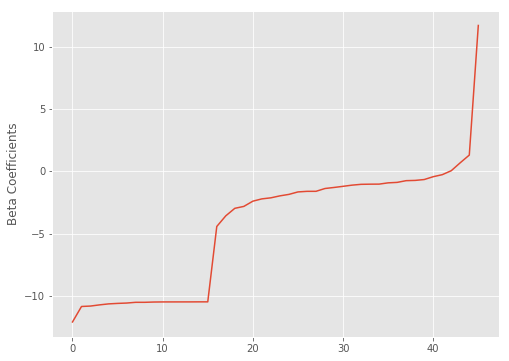

In [427]:
# Creating an instance of LogisticRegression

lr = LogisticRegression()

lrModel = lr.fit(train) # Fitting the model on training set

# Plotting the coefficients of the model in sorted order 

plt.rcParams["figure.figsize"] = (8,6)

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')

#### Feature Importance

In [428]:
coefsArray = np.array(lrModel.coefficients)  # convert to np.array
coefsDF = pd.DataFrame(coefsArray, columns=['coefs'])  # to pandas

coefsDF = coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
coefsDF.sort_values('coefs', inplace=True)  # Sort them

In [429]:
coefsDF.head(10) # top 10 negatively correlated features

,coefs,name
31,-12.075257,country_Luxembourg
29,-10.832592,country_Serbia
16,-10.798083,country_Romania
42,-10.703578,country_Japan
40,-10.624561,country_China
27,-10.585492,country_Brazil
43,-10.557051,country_Albania
33,-10.498333,country_Lithuania
44,-10.498107,country_Montenegro
41,-10.475920,country_Slovakia


In [430]:
coefsDF.tail(10) # top 10 positively correlated features

,coefs,name
6,-0.878254,country_Australia
15,-0.740021,country_Canada
30,-0.719271,country_Morocco
10,-0.649615,country_Germany
7,-0.421640,country_Portugal
9,-0.260517,country_Austria
45,0.058117,price
39,0.699032,country_Switzerland
32,1.312511,country_India
34,11.709417,country_England


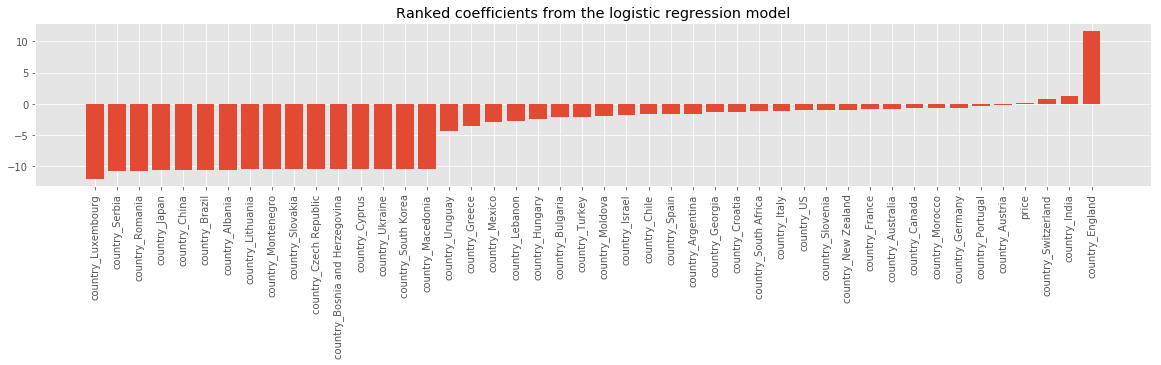

In [431]:
# Plotting the bar chart

plt.rcParams["figure.figsize"] = (20,3)

plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF.coefs)
plt.title('Ranked coefficients from the logistic regression model')
plt.show()

Train AUC value

In [432]:
# Fitted Model AUC value

summary = lrModel.summary
print("Train AUC:", summary.areaUnderROC)

Train AUC: 0.8289851748321486


Train ROC curve

Train AUC: 0.8289851748321486


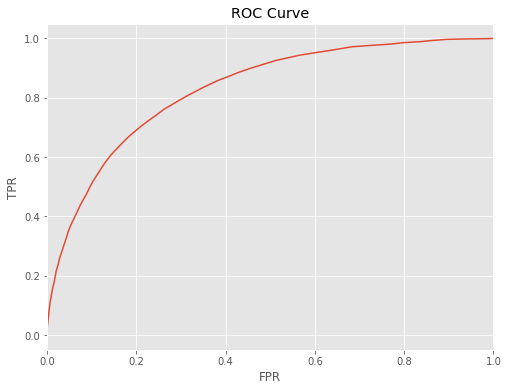

In [433]:
roc = summary.roc.toPandas()
roc.head()

plt.rcParams["figure.figsize"] = (8,6)

roc.plot(x='FPR', y='TPR', style='-', legend=False)
plt.title('ROC Curve')
plt.ylabel('TPR')

print('Train AUC:', summary.areaUnderROC)

Precision-recall curve

Text(0, 0.5, 'precision')

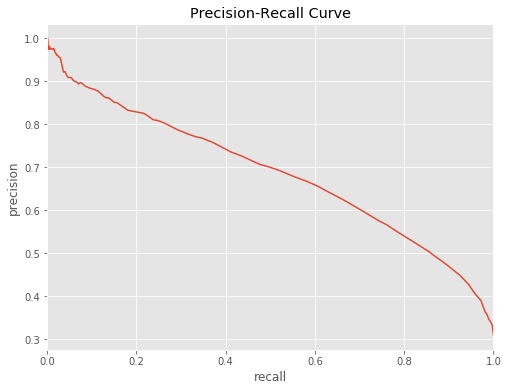

In [434]:
pr = summary.pr.toPandas()
pr.plot(x='recall', y='precision', style='-', legend=False)
plt.title('Precision-Recall Curve')
plt.ylabel('precision')

Test AUC

In [435]:
fittedTest = lrModel.transform(test)

fittedTest.select("label", "prediction", "rawPrediction").show(5, False)


aucEvaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

print('Test AUC:', aucEvaluator.evaluate(lrModel.transform(test)))
print('Train AUC:', summary.areaUnderROC)

# saving the baseline test auc value
test_auc_baseline = aucEvaluator.evaluate(lrModel.transform(test))

+-----+----------+----------------------------------------+
|label|prediction|rawPrediction                           |
+-----+----------+----------------------------------------+
|0.0  |0.0       |[3.0214790476284916,-3.0214790476284916]|
|0.0  |0.0       |[2.963362102274679,-2.963362102274679]  |
|0.0  |0.0       |[2.9052451569208664,-2.9052451569208664]|
|0.0  |0.0       |[2.8471282115670533,-2.8471282115670533]|
|0.0  |0.0       |[2.8471282115670533,-2.8471282115670533]|
+-----+----------+----------------------------------------+
only showing top 5 rows

Test AUC: 0.8252626976142586
Train AUC: 0.8289851748321486


## Part 3

### Logistic regression with hyperparameter optimization (& pipeline) with minimal features

Setting up the training and test sets for the pipeline for hyperparameter tuning

In [436]:
wine_reg_pipeline.show(2)

+-------+-----+----------+
|country|price|pointLevel|
+-------+-----+----------+
|     US|235.0|         1|
|  Spain|110.0|         1|
+-------+-----+----------+
only showing top 2 rows



In [437]:
train, test = wine_reg_pipeline.randomSplit([0.7, 0.3], seed = 123)

train.show(2)

+---------+-----+----------+
|  country|price|pointLevel|
+---------+-----+----------+
|  Albania| 20.0|         0|
|Argentina|  5.0|         0|
+---------+-----+----------+
only showing top 2 rows



Setting up the components and stages for pipeline

In [438]:
rForm = RFormula()
lr = LogisticRegression()

Setting up the pipeline

In [439]:
from pyspark.ml import Pipeline

stages = [rForm, lr]
pipeline = Pipeline().setStages(stages)

Building the grid of hyperparameters

In [440]:
test.printSchema()

root
 |-- country: string (nullable = true)
 |-- price: double (nullable = true)
 |-- pointLevel: integer (nullable = false)



In [441]:
from pyspark.ml.tuning import ParamGridBuilder

params = ParamGridBuilder()\
  .addGrid(rForm.formula, [
    "pointLevel ~ .-country"])\
  .addGrid(lr.elasticNetParam, [0.0, 0.01, 0.05, 0.1, 0.5, 1.0])\
  .addGrid(lr.regParam, [0.0, 0.01, 0.05, 0.1, 0.25, 0.5, 1.0])\
  .build()

Defining an instance of the evaluator

In [442]:
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

Fitting the hyper parameters on the validation set

In [443]:
from pyspark.ml.tuning import TrainValidationSplit

tvs = TrainValidationSplit()\
  .setTrainRatio(0.75)\
  .setEstimatorParamMaps(params)\
  .setEstimator(pipeline)\
  .setEvaluator(evaluator)

Fitting the model with multiple combination of hyperparameters on the training set

In [444]:
tvsFitted = tvs.fit(train)

In [445]:
evaluator.evaluate(tvsFitted.transform(train))

0.8262924419118728

In [446]:
bestModel = tvsFitted.bestModel

In [447]:
bestLR = bestModel.stages[-1]._java_obj

print('Best model elasticNet parameter: ', bestLR.getElasticNetParam())
print('Best model regression parameter: ', bestLR.getRegParam())

Best model elasticNet parameter:  0.0
Best model regression parameter:  0.25


Evaluating the best model's performance on test set

In [448]:
evaluator.evaluate(tvsFitted.transform(test))

0.8285254152570773

In [449]:
# Saving the test auc value for best model
best_model_test_auc = evaluator.evaluate(tvsFitted.transform(test))

print('Best model Test AUC:', best_model_test_auc)

Best model Test AUC: 0.8285254152570772


Improvement in model performance on test set from hyperparameter tuning

In [450]:
print('Test AUC for model without hyperparameter tuning:', test_auc_baseline)

Test AUC for model without hyperparameter tuning: 0.8252626976142582


In [451]:
print('Improvement in AUC from hyperparameter tuning:', best_model_test_auc - test_auc_baseline)

Improvement in AUC from hyperparameter tuning: 0.0032627176428190463


The AUC value comparison is not an apples to apples comparison as we are comparing,
1. best_model_test_auc (AUC value from logistic regression model with hyperparameter tuning on features; price variable only)
2. test_auc_baseline (AUC value from logistic regression model on limited features; country and price variables only)

But the hyperparameter tuned model with feature; price gives a higher AUC than the logistic regression model (without hyperparameter tuning) having limited features; country and price.